# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_initial_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters fof Experiment ---
dim_exp = 32  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 20000 # Example number of data points
iterations_exp_initial = 1000 # Iterations for initial training phase
iterations_exp_long = 500000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 128     # number of hidden units
layers = 8      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section ===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(x_points): # x_points is N x dim
    """
    Computes the target function psi(x) = ||x||_2^2 for the given problem.
    """
    return euclid_norm_sq(x_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)



def evaluate_learned_J_HJ_approx(x_points, model):
    """
    Evaluates the learned prior J(x) using the method of characteristics
    for quadratic Hamiltonian H(p) = 0.5 * ||p||^2.
    
    The method of characteristics gives us:
    J(grad_psi(x)) = <x, grad_psi(x)> - 0.5 * ||grad_psi(x)||^2 - psi(x)
    
    To get J(x), we need to find the x' such that grad_psi(x') = x,
    then evaluate the formula at x'.
    
    For this specific problem where psi(x) = ||x||^2, we have grad_psi(x) = 2x,
    so to evaluate J(y), we need x = y/2.
    
    Args:
        x_points: numpy array of shape (N, dim) containing evaluation points
        model: trained LPN model
    
    Returns:
        J_est: numpy array of shape (N,) containing estimated J values
    """
    # To evaluate J(x), we need to find x' such that grad_psi(x') = x
    # For the learned psi approximating ||x||^2, grad_psi(x) ≈ 2x
    # So x' ≈ x/2 to get grad_psi(x') ≈ x
    
    # However, for a general learned model, we'd need to solve the inverse problem
    # For simplicity, assuming the model learned psi(x) ≈ ||x||^2 well,
    # we use the approximation x' = x/2
    
    x_prime = x_points / 2.0
    
    # Convert to tensor
    x_tensor = torch.from_numpy(x_prime).float().to(device)
    x_tensor.requires_grad_(True)
    
    # Get psi(x')
    psi_x = model.scalar(x_tensor)
    
    # Get gradient of psi at x'
    grad_psi = model(x_tensor)
    
    # Compute inner product <x', grad_psi(x')>
    inner_prod = torch.sum(x_tensor * grad_psi, dim=1, keepdim=True)
    
    # Compute ||grad_psi(x')||^2
    grad_psi_norm_sq = torch.sum(grad_psi * grad_psi, dim=1, keepdim=True)
    
    # Apply the formula: this gives J(grad_psi(x')) ≈ J(x)
    J_est = inner_prod - 0.5 * grad_psi_norm_sq - psi_x
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_psi_true = x1_0_psi_true
        x2_0_J_true = x1_0_J_true

    x1_0_psi_est = cvx(x1_0_points, model)
    x1_0_J_est = evaluate_learned_J_HJ_approx(x1_0_points, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        x2_0_J_est = evaluate_learned_J_HJ_approx(x2_0_points, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
    print(x1_0_J_est.shape)
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\psi$ for $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"$\psi(x_1,0,...)$ - Dim {dim}, Concave Prior")
    plt.xlabel('$x_1$')
    plt.ylabel('$\psi(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\psi$ for $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"$\psi(0,x_2,0,...)$ - Dim {dim}, Concave Prior")
        plt.xlabel('$x_2$')
        plt.ylabel('$\psi(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned J)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, Concave Prior")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned J)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, Concave Prior")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)


<>:121: SyntaxWarning: invalid escape sequence '\p'
<>:122: SyntaxWarning: invalid escape sequence '\p'
<>:124: SyntaxWarning: invalid escape sequence '\p'
<>:126: SyntaxWarning: invalid escape sequence '\p'
<>:131: SyntaxWarning: invalid escape sequence '\p'
<>:132: SyntaxWarning: invalid escape sequence '\p'
<>:134: SyntaxWarning: invalid escape sequence '\p'
<>:136: SyntaxWarning: invalid escape sequence '\p'
<>:121: SyntaxWarning: invalid escape sequence '\p'
<>:122: SyntaxWarning: invalid escape sequence '\p'
<>:124: SyntaxWarning: invalid escape sequence '\p'
<>:126: SyntaxWarning: invalid escape sequence '\p'
<>:131: SyntaxWarning: invalid escape sequence '\p'
<>:132: SyntaxWarning: invalid escape sequence '\p'
<>:134: SyntaxWarning: invalid escape sequence '\p'
<>:136: SyntaxWarning: invalid escape sequence '\p'
/scratch/16122989/ipykernel_463907/3280289920.py:121: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\psi$)")


In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
x_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(x_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

x_j_exp_tensor = torch.from_numpy(x_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: x_j_exp_tensor shape {x_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")


# --- ADD THIS TO MOVE DATA TO GPU ---
x_j_exp_tensor = x_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: x_j_exp_tensor shape torch.Size([20000, 32]), psi_samples_exp_tensor shape torch.Size([20000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1000):
     single_iteration(i, data_points_exp, lpn_model_concave_quad, optimizer_concave_quad, x_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training with a reduced learning rate
for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_concave_quad, optimizer_concave_quad, x_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 29880.82421875


iteration 0 loss 53177.96875


iteration 5000 loss 241.7548370361328


iteration 10000 loss 188.7000274658203


iteration 15000 loss 119.29386138916016


iteration 20000 loss 1.1185303926467896


iteration 25000 loss 0.29995447397232056


iteration 30000 loss 0.1368321180343628


iteration 35000 loss 0.0739077627658844


iteration 40000 loss 0.04004254564642906


iteration 45000 loss 0.023764370009303093


iteration 50000 loss 0.01475529931485653


iteration 55000 loss 0.015684647485613823


iteration 60000 loss 0.006434236653149128


iteration 65000 loss 0.0049760183319449425


iteration 70000 loss 0.018545858561992645


iteration 75000 loss 0.27049779891967773


iteration 80000 loss 0.005700967274606228


iteration 85000 loss 0.0012765631545335054


iteration 90000 loss 0.0010369656374678016


iteration 95000 loss 0.2526358366012573


iteration 100000 loss 0.0007033169968053699


iteration 105000 loss 0.0006007027695886791


iteration 110000 loss 0.0006287413998506963


iteration 115000 loss 0.0009547036024741828


iteration 120000 loss 0.00046796281822025776


iteration 125000 loss 0.0004388389934320003


iteration 130000 loss 0.0004210153128951788


iteration 135000 loss 0.0004373862175270915


iteration 140000 loss 0.00044066819828003645


iteration 145000 loss 0.35834935307502747


iteration 150000 loss 0.0003789880720432848


iteration 155000 loss 0.0003890449879691005


iteration 160000 loss 0.2965794801712036


iteration 165000 loss 0.0007399804890155792


iteration 170000 loss 0.0015172002604231238


iteration 175000 loss 0.0003584902733564377


iteration 180000 loss 0.03512325882911682


iteration 185000 loss 0.00041426284587942064


iteration 190000 loss 0.00033882420393638313


iteration 195000 loss 0.000560002401471138


iteration 200000 loss 0.00033472824725322425


iteration 205000 loss 0.23143281042575836


iteration 210000 loss 1.8387019634246826


iteration 215000 loss 0.000800816691480577


iteration 220000 loss 0.016813455149531364


iteration 225000 loss 0.00034518883330747485


iteration 230000 loss 0.0003559086180757731


iteration 235000 loss 0.0018899791175499558


iteration 240000 loss 3.974172592163086


iteration 245000 loss 0.000675976974889636


iteration 250000 loss 0.00041292121750302613


iteration 255000 loss 0.00035569441388361156


iteration 260000 loss 0.008222592063248158


iteration 265000 loss 0.00030633845017291605


iteration 270000 loss 0.00029358090250752866


iteration 275000 loss 0.00031784921884536743


iteration 280000 loss 0.0003016940609086305


iteration 285000 loss 0.22199676930904388


iteration 290000 loss 0.09036524593830109


iteration 295000 loss 3.5184996128082275


iteration 300000 loss 0.0002784216485451907


iteration 305000 loss 0.00030857266392558813


iteration 310000 loss 0.0003113752754870802


iteration 315000 loss 0.0002697513555176556


iteration 320000 loss 0.00033356918720528483


iteration 325000 loss 0.00034947608946822584


iteration 330000 loss 0.00026994082145392895


iteration 335000 loss 1.5577468872070312


iteration 340000 loss 0.0003295268688816577


iteration 345000 loss 0.0010167212458327413


iteration 350000 loss 0.00026299405726604164


iteration 355000 loss 0.0002800842630676925


iteration 360000 loss 0.006000168155878782


iteration 365000 loss 0.0011499256361275911


iteration 370000 loss 2.7834134101867676


iteration 375000 loss 0.010785732418298721


iteration 380000 loss 0.00043663251562975347


iteration 385000 loss 0.0002678086166270077


iteration 390000 loss 0.00023510526807513088


iteration 395000 loss 0.0060009644366800785


iteration 400000 loss 0.00026191744836978614


iteration 405000 loss 0.23131009936332703


iteration 410000 loss 0.04123476892709732


iteration 415000 loss 0.0034410362131893635


iteration 420000 loss 0.0002354725729674101


iteration 425000 loss 0.0034332708455622196


iteration 430000 loss 0.0002827404532581568


iteration 435000 loss 0.022163888439536095


iteration 440000 loss 0.023848187178373337


iteration 445000 loss 0.0025898737367242575


iteration 450000 loss 0.00031849098741076887


iteration 455000 loss 0.00023958350357133895


iteration 460000 loss 0.0003533810668159276


iteration 465000 loss 0.0008830665610730648


iteration 470000 loss 0.030097074806690216


iteration 475000 loss 0.0005381617229431868


iteration 480000 loss 0.0002442373661324382


iteration 485000 loss 2.8308589458465576


iteration 490000 loss 0.07959942519664764


iteration 495000 loss 0.00021935910626780242


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=32) ---
(50,)


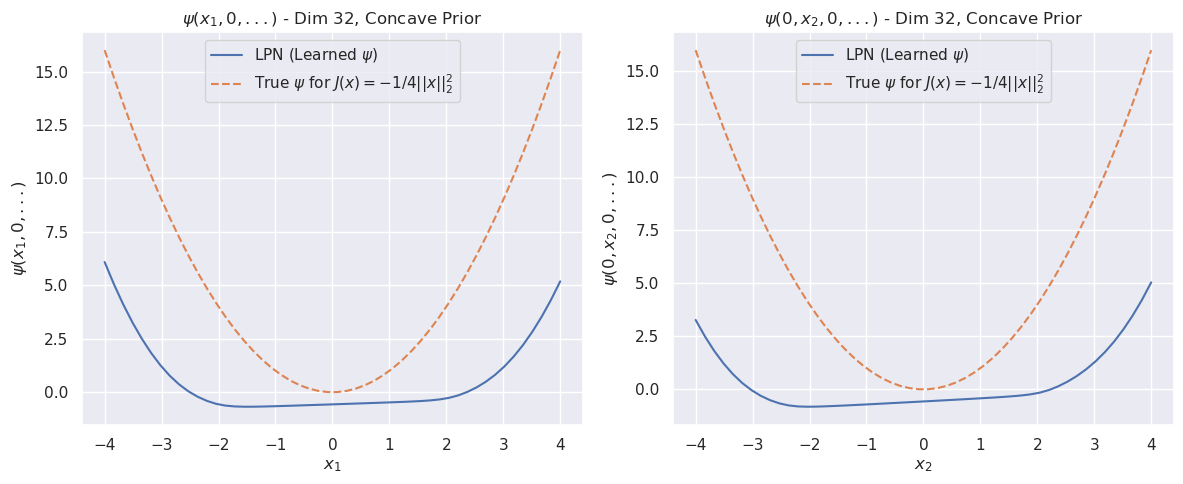

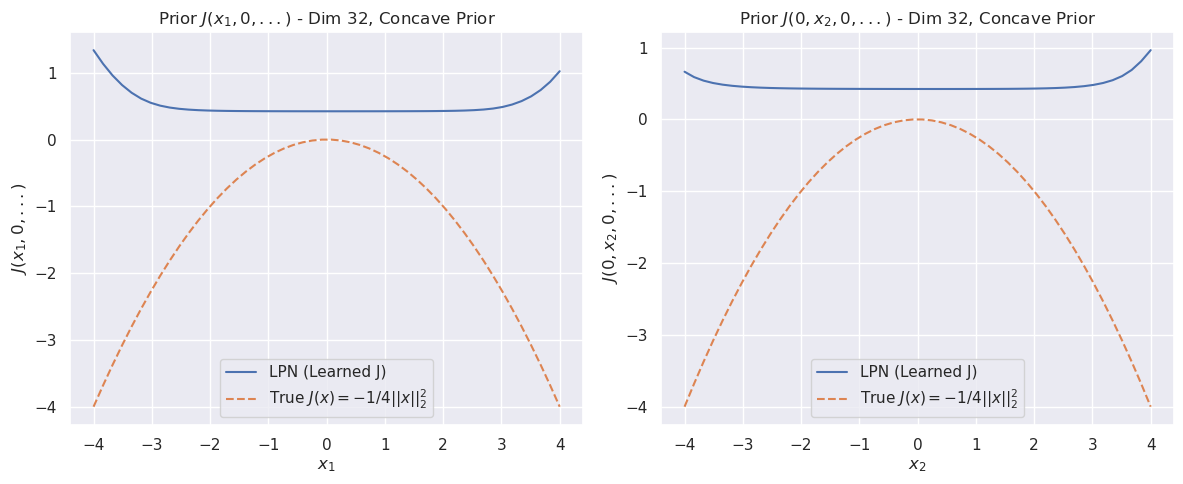

In [8]:
# --- Plot the results of the new experiment ---
plot_all_concave_quad(lpn_model_concave_quad, a_exp, spacing, INVERT_MODE, dim_exp)
#evaluate_learned_H(lpn_model_concave_quad, a_exp, spacing, dim_exp)

Generated G samples: G_samples_tensor shape torch.Size([20000, 1])

--- Plotting Updated Prior j_hat(y) (Dim=32) ---


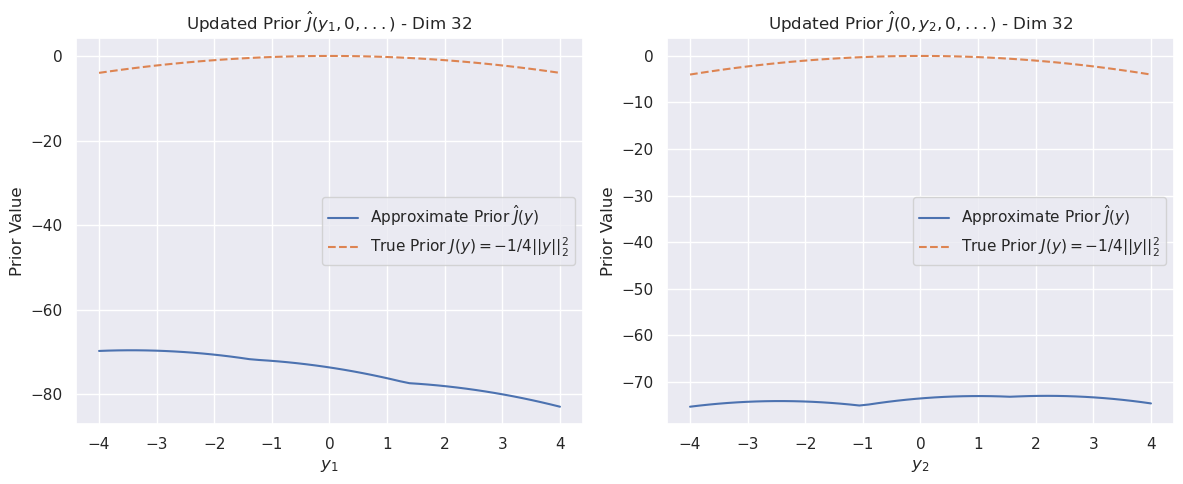

In [9]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = x_j_exp_tensor.clone()
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach() 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")


def evaluate_updated_prior_J_hat(y_points, model, x_k_np):
    """
    Implements the approximate prior.
    """
    
    # Pre-compute y_k = grad psi(x_k) from the training data
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    y_k_tensor = model(x_k_tensor)
    y_k_np = y_k_tensor.detach().cpu().numpy()
    
    # Compute S(x_k, 1) = psi(x_k, t=1) from the LPN
    S_x_k = model.scalar(x_k_tensor)  # Shape (K, 1)
    S_x_k_np = S_x_k.detach().cpu().numpy().flatten()  # Shape (K,)
    
    # The constant term simplifies to just S(x_k, 1)
    # Because: J_tilde(y_k) + 1/2||x_k - y_k||^2 
    #        = [S(x_k,1) - 1/2||x_k - y_k||^2] + 1/2||x_k - y_k||^2 
    #        = S(x_k, 1)
    constants_k = S_x_k_np  # Shape (K,)
    
    # Term 3: -1/2 * ||x_k - y||^2
    # Broadcasting: x_k_np (K, 1, dim), y_points (1, N, dim) -> (K, N)
    term3 = -0.5 * np.sum((x_k_np[:, np.newaxis, :] - y_points[np.newaxis, :, :])**2, axis=2)
    
    # Term 4: 1/4 * ||y - y_k||^2
    # Broadcasting: y_points (1, N, dim), y_k_np (K, 1, dim) -> (K, N)
    term4 = 0.25 * np.sum((y_points[np.newaxis, :, :] - y_k_np[:, np.newaxis, :])**2, axis=2)

    term5 = 0.5 * np.sum((x_k_np[:, np.newaxis, :])**2, axis=2)
    all_terms = term5 - constants_k[:, np.newaxis] + term3 
    
    # # Combine all terms: constants_k (K, 1) + term3 (K, N) + term4 (K, N)
    # all_terms = constants_k[:, np.newaxis] + term3 + term4
    
    # Take the max over K dimension
    j_hat_est = np.max(all_terms, axis=0)
    
    return j_hat_est

def plot_updated_prior_J_hat(model, a, spacing, dim, x_k_np):
    """
    Generates cross-section plots for the prior j_hat(y) from the "Update".
    """
    print(f"\n--- Plotting Updated Prior j_hat(y) (Dim={dim}) ---")
    xi, y1_0_points, y2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute true prior J(y)
    y1_0_J_true = prior_true_concave_quad(y1_0_points)
    
    # Compute estimated prior j_hat(y)
    y1_0_J_hat_est = evaluate_updated_prior_J_hat(y1_0_points, model, x_k_np)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, y1_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
    plt.plot(xi, y1_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
    plt.grid(True)
    plt.title(f"Updated Prior $\\hat{{J}}(y_1,0,...)$ - Dim {dim}")
    plt.xlabel('$y_1$')
    plt.ylabel('Prior Value')
    plt.legend()

    if dim > 1:
        y2_0_J_true = prior_true_concave_quad(y2_0_points)
        y2_0_J_hat_est = evaluate_updated_prior_J_hat(y2_0_points, model, x_k_np)
        
        plt.subplot(1, 2, 2)
        plt.plot(xi, y2_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
        plt.plot(xi, y2_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
        plt.grid(True)
        plt.title(f"Updated Prior $\\hat{{J}}(0,y_2,0,...)$ - Dim {dim}")
        plt.xlabel('$y_2$')
        plt.ylabel('Prior Value')
        plt.legend()
        
    plt.tight_layout()
    plt.show()


# We use the original training data 'x_j_exp_np' as our set of x_k points.
#subset_size = 1000 
x_k_subset_np = x_j_exp_np#[:subset_size, :]

plot_updated_prior_J_hat(lpn_model_concave_quad, a_exp, spacing, dim_exp, x_k_subset_np)


In [10]:
# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(iterations_exp_initial):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 # Use a smaller learning rate for the long phase
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 25085.859375


iteration 0 loss 136689.5


iteration 5000 loss 81.84883880615234


iteration 10000 loss 52.00676727294922


iteration 15000 loss 22.194734573364258


iteration 20000 loss 10.938843727111816


iteration 25000 loss 3.6740663051605225


iteration 30000 loss 1.3412364721298218


iteration 35000 loss 0.6063977479934692


iteration 40000 loss 0.3346186578273773


iteration 45000 loss 0.20903520286083221


iteration 50000 loss 0.14186468720436096


iteration 55000 loss 0.09964639693498611


iteration 60000 loss 0.0903996080160141


iteration 65000 loss 0.05493425205349922


iteration 70000 loss 0.03973846882581711


iteration 75000 loss 0.030349215492606163


iteration 80000 loss 0.023614101111888885


iteration 85000 loss 0.01846582069993019


iteration 90000 loss 0.033684782683849335


iteration 95000 loss 0.01191389374434948


iteration 100000 loss 0.009708598256111145


iteration 105000 loss 0.007887454703450203


iteration 110000 loss 0.00653156777843833


iteration 115000 loss 0.017024550586938858


iteration 120000 loss 0.004583484493196011


iteration 125000 loss 0.003922278061509132


iteration 130000 loss 0.009271452203392982


iteration 135000 loss 0.03612588718533516


iteration 140000 loss 0.0023750141263008118


iteration 145000 loss 0.002041369676589966


iteration 150000 loss 0.001760596176609397


iteration 155000 loss 0.0015447816113010049


iteration 160000 loss 1.585770845413208


iteration 165000 loss 0.0012437860714271665


iteration 170000 loss 0.0068790907971560955


iteration 175000 loss 0.0009604553924873471


iteration 180000 loss 0.0009001176804304123


iteration 185000 loss 0.0007901724893599749


iteration 190000 loss 0.0010810534004122019


iteration 195000 loss 0.000635405711364001


iteration 200000 loss 0.0005755312740802765


iteration 205000 loss 0.0005388276185840368


iteration 210000 loss 0.000493152067065239


iteration 215000 loss 0.0004779026785399765


iteration 220000 loss 2.320647716522217


iteration 225000 loss 0.000442716118413955


iteration 230000 loss 0.0379585325717926


iteration 235000 loss 0.0003940039605367929


iteration 240000 loss 0.00044170068576931953


iteration 245000 loss 0.11094136536121368


iteration 250000 loss 0.0010511977598071098


iteration 255000 loss 0.002334245713427663


iteration 260000 loss 0.00032531912438571453


iteration 265000 loss 0.0003063863259740174


iteration 270000 loss 0.032560184597969055


iteration 275000 loss 0.0969417542219162


iteration 280000 loss 0.00041125420830212533


iteration 285000 loss 0.0002783519448712468


iteration 290000 loss 0.06388973444700241


iteration 295000 loss 0.0002783903619274497


iteration 300000 loss 0.7957634329795837


iteration 305000 loss 0.00025312358047813177


iteration 310000 loss 0.00028389072394929826


iteration 315000 loss 0.00025307273608632386


iteration 320000 loss 0.0006429642671719193


iteration 325000 loss 0.02303113415837288


iteration 330000 loss 0.0003787072782870382


iteration 335000 loss 0.00024457453400827944


iteration 340000 loss 0.0015575878787785769


iteration 345000 loss 0.0002358666533837095


iteration 350000 loss 0.00025036963052116334


iteration 355000 loss 0.00023838429478928447


iteration 360000 loss 0.00022013485431671143


iteration 365000 loss 0.000217173044802621


iteration 370000 loss 2.3281490802764893


iteration 375000 loss 0.00031842131284065545


iteration 380000 loss 0.0005270876572467387


iteration 385000 loss 0.00021551232202909887


iteration 390000 loss 0.00021507915516849607


iteration 395000 loss 0.0002532610378693789


iteration 400000 loss 0.0009134610882028937


iteration 405000 loss 0.0002113857481162995


iteration 410000 loss 0.00019595131743699312


iteration 415000 loss 0.00032182357972487807


iteration 420000 loss 0.005583145190030336


iteration 425000 loss 0.01052771881222725


iteration 430000 loss 0.00019072943541686982


iteration 435000 loss 0.0012783099664375186


iteration 440000 loss 0.0001898297923617065


iteration 445000 loss 0.00018474643002264202


iteration 450000 loss 0.00020276865689083934


iteration 455000 loss 0.00020727851369883865


iteration 460000 loss 0.00047013413859531283


iteration 465000 loss 0.04776625335216522


iteration 470000 loss 0.00022312898363452405


iteration 475000 loss 0.00018251642177347094


iteration 480000 loss 0.00017524034774396569


iteration 485000 loss 0.00024704032693989575


iteration 490000 loss 0.0001700251887086779


iteration 495000 loss 0.0001719511637929827


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from G(x) Network ---


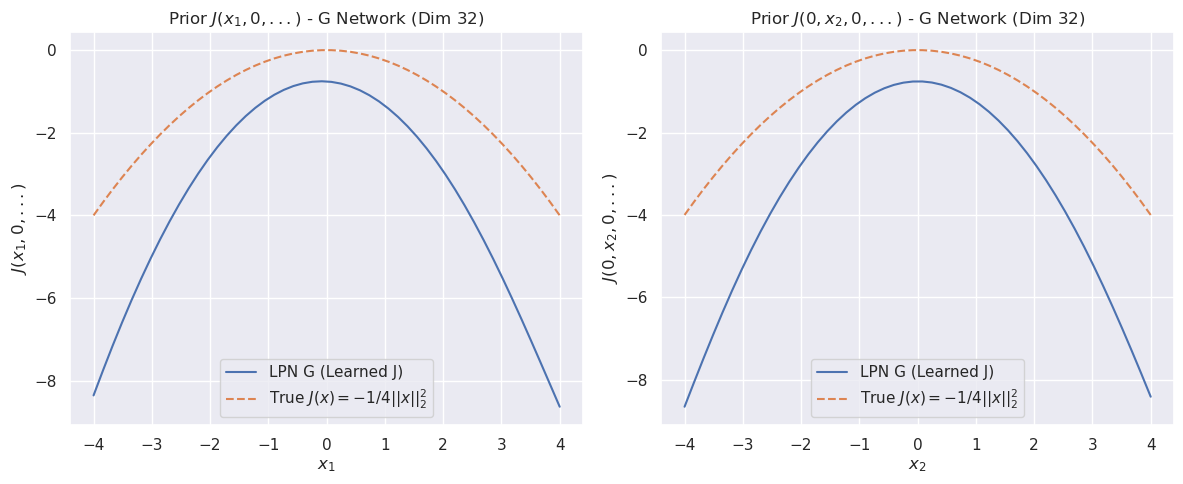

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from G(x) Network ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN G (Learned J)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - G Network (Dim {dim})")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN G (Learned J)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - G Network (Dim {dim})")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)

L1 loss -- Train

In [12]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l1 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad_l1 = torch.optim.Adam(lpn_model_concave_quad_l1.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1000):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l1, optimizer_concave_quad_l1, x_j_exp_tensor, psi_samples_exp_tensor, loss_type=1, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad_l1.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l1, optimizer_concave_quad_l1, x_j_exp_tensor, psi_samples_exp_tensor, loss_type=1, gamma_loss=None)

torch.save(lpn_model_concave_quad_l1.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l1.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---
iteration 0 loss 170.58779907226562


iteration 0 loss 11.929108619689941


iteration 5000 loss 7.54613733291626


iteration 10000 loss 1.1471900939941406


iteration 15000 loss 0.9506849646568298


iteration 20000 loss 0.877979576587677


iteration 25000 loss 0.6004109978675842


iteration 30000 loss 0.7071561813354492


iteration 35000 loss 0.7154501080513


iteration 40000 loss 0.340551495552063


iteration 45000 loss 0.32417771220207214


iteration 50000 loss 0.9167044758796692


iteration 55000 loss 0.5750501751899719


iteration 60000 loss 0.40035760402679443


iteration 65000 loss 0.5786735415458679


iteration 70000 loss 0.2535715401172638


iteration 75000 loss 0.7794517874717712


iteration 80000 loss 0.7050731182098389


iteration 85000 loss 0.6938818693161011


iteration 90000 loss 0.2763989269733429


iteration 95000 loss 0.5893065333366394


iteration 100000 loss 0.5335910320281982


iteration 105000 loss 0.9012144207954407


iteration 110000 loss 0.46546024084091187


iteration 115000 loss 0.34661436080932617


iteration 120000 loss 0.47984325885772705


iteration 125000 loss 1.6719276905059814


iteration 130000 loss 0.46805185079574585


iteration 135000 loss 0.6928914785385132


iteration 140000 loss 1.6796270608901978


iteration 145000 loss 0.2506641745567322


iteration 150000 loss 0.5124974846839905


iteration 155000 loss 0.4980897307395935


iteration 160000 loss 0.873780369758606


iteration 165000 loss 0.3661622405052185


iteration 170000 loss 0.32184526324272156


iteration 175000 loss 0.6442771553993225


iteration 180000 loss 0.47776150703430176


iteration 185000 loss 0.32325616478919983


iteration 190000 loss 1.168501377105713


iteration 195000 loss 0.3268663287162781


iteration 200000 loss 0.2609546184539795


iteration 205000 loss 0.4304908215999603


iteration 210000 loss 0.6306633949279785


iteration 215000 loss 0.6001943349838257


iteration 220000 loss 0.4844299256801605


iteration 225000 loss 0.6142899394035339


iteration 230000 loss 0.2851940989494324


iteration 235000 loss 0.46546298265457153


iteration 240000 loss 0.7060307264328003


iteration 245000 loss 0.453721284866333


iteration 250000 loss 0.4291430413722992


iteration 255000 loss 0.7597901225090027


iteration 260000 loss 0.22624003887176514


iteration 265000 loss 0.9839555621147156


iteration 270000 loss 0.3410457968711853


iteration 275000 loss 0.28946518898010254


iteration 280000 loss 0.37990331649780273


iteration 285000 loss 0.3948541283607483


iteration 290000 loss 0.8238758444786072


iteration 295000 loss 0.5243452787399292


iteration 300000 loss 0.5553203821182251


iteration 305000 loss 0.3994144797325134


iteration 310000 loss 0.5665929317474365


iteration 315000 loss 0.7534955143928528


iteration 320000 loss 0.9130476117134094


iteration 325000 loss 1.0262783765792847


iteration 330000 loss 0.25892141461372375


iteration 335000 loss 0.4727069139480591


iteration 340000 loss 1.1815592050552368


iteration 345000 loss 0.4378169775009155


iteration 350000 loss 0.5167245864868164


iteration 355000 loss 0.43787381052970886


iteration 360000 loss 0.34447190165519714


iteration 365000 loss 0.46485063433647156


iteration 370000 loss 0.24139726161956787


iteration 375000 loss 1.1401481628417969


iteration 380000 loss 0.6927093863487244


iteration 385000 loss 0.18586407601833344


iteration 390000 loss 0.7304283976554871


iteration 395000 loss 0.16545476019382477


iteration 400000 loss 0.7918858528137207


iteration 405000 loss 0.7805878520011902


iteration 410000 loss 0.7295318245887756


iteration 415000 loss 0.21961146593093872


iteration 420000 loss 0.638231635093689


iteration 425000 loss 0.4191608428955078


iteration 430000 loss 0.5759934186935425


iteration 435000 loss 0.33532941341400146


iteration 440000 loss 0.32390180230140686


iteration 445000 loss 0.5986784100532532


iteration 450000 loss 0.13457219302654266


iteration 455000 loss 0.5285180807113647


iteration 460000 loss 0.4365769326686859


iteration 465000 loss 0.48952314257621765


iteration 470000 loss 0.23897314071655273


iteration 475000 loss 1.1271849870681763


iteration 480000 loss 0.774636447429657


iteration 485000 loss 0.4282604455947876


iteration 490000 loss 0.7643547654151917


iteration 495000 loss 0.6796878576278687


L1 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=32) ---
(50,)


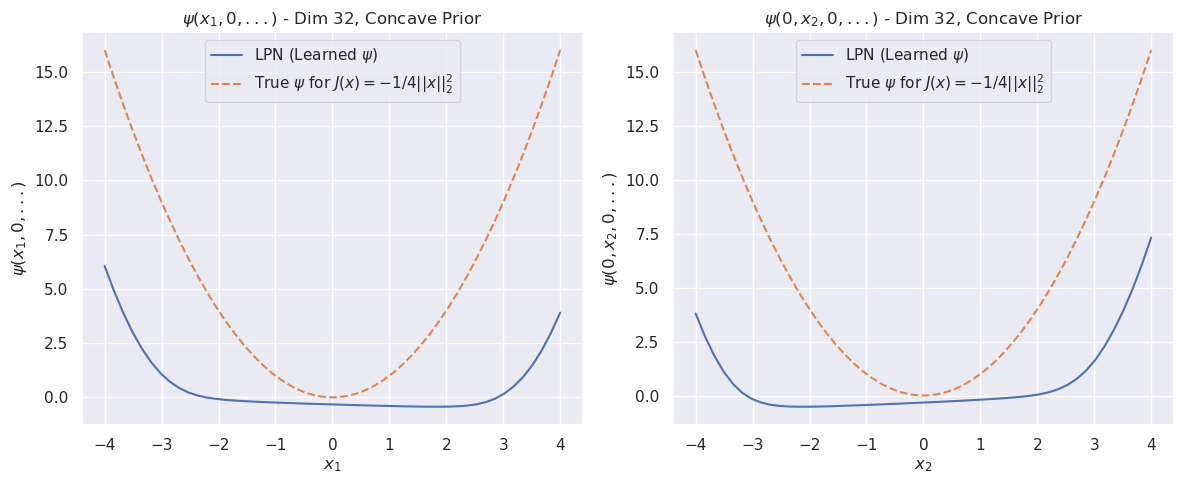

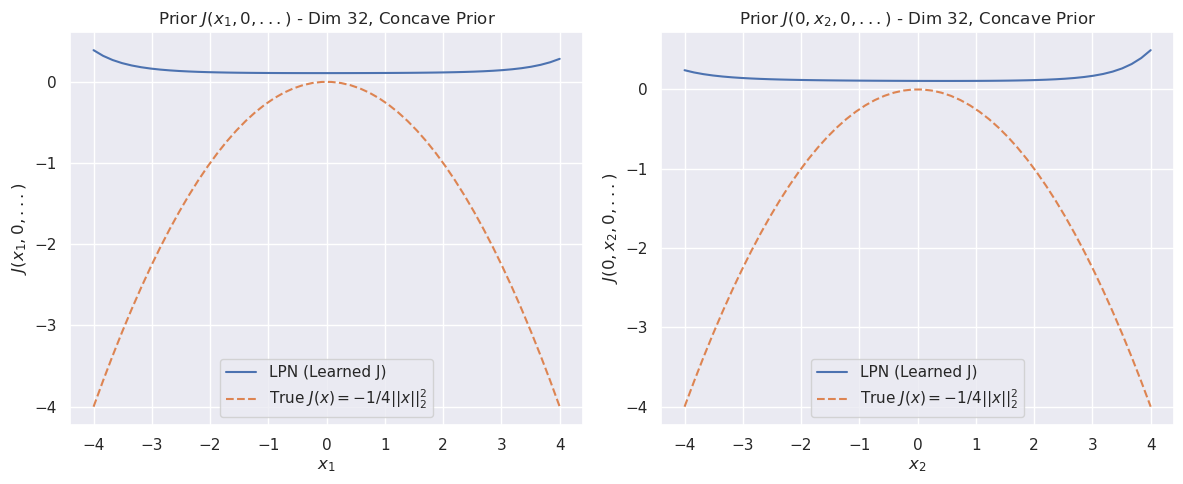

In [13]:
# --- Plot the results of the new experiment ---
plot_all_concave_quad(lpn_model_concave_quad_l1, a_exp, spacing, INVERT_MODE, dim_exp)
#evaluate_learned_H(lpn_model_concave_quad_l1, a_exp, spacing, dim_exp)

Generated G samples: G_samples_tensor shape torch.Size([20000, 1])

--- Plotting Updated Prior j_hat(y) (Dim=32) ---


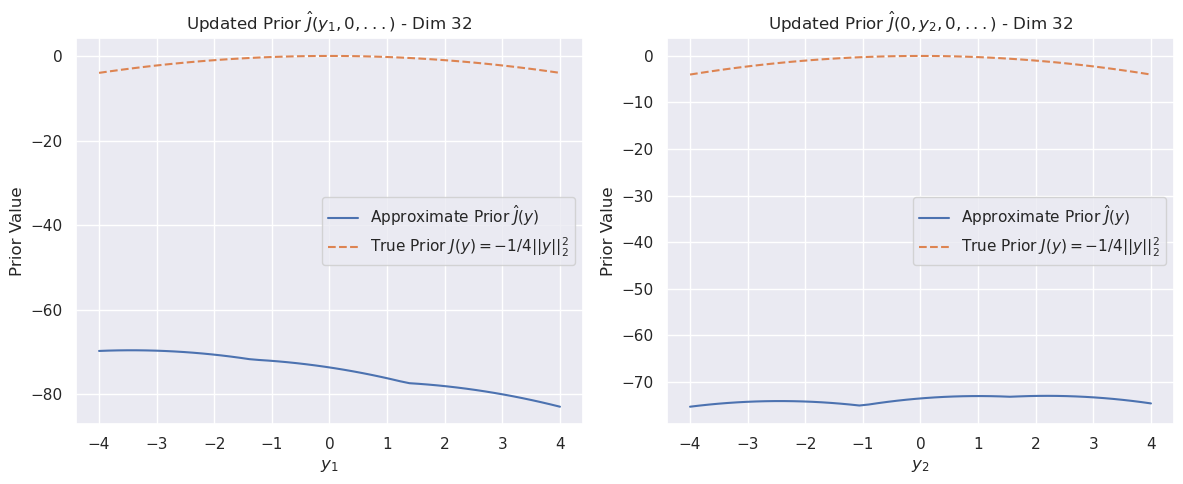

In [14]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = x_j_exp_tensor.clone()
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l1.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l1(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach() 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")


def evaluate_updated_prior_J_hat(y_points, model, x_k_np):
    """
    Implements the approximate prior.
    """
    
    # Pre-compute y_k = grad psi(x_k) from the training data
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    y_k_tensor = model(x_k_tensor)
    y_k_np = y_k_tensor.detach().cpu().numpy()
    
    # Compute S(x_k, 1) = psi(x_k, t=1) from the LPN
    S_x_k = model.scalar(x_k_tensor)  # Shape (K, 1)
    S_x_k_np = S_x_k.detach().cpu().numpy().flatten()  # Shape (K,)
    
    # The constant term simplifies to just S(x_k, 1)
    # Because: J_tilde(y_k) + 1/2||x_k - y_k||^2 
    #        = [S(x_k,1) - 1/2||x_k - y_k||^2] + 1/2||x_k - y_k||^2 
    #        = S(x_k, 1)
    constants_k = S_x_k_np  # Shape (K,)
    
    # Term 3: -1/2 * ||x_k - y||^2
    # Broadcasting: x_k_np (K, 1, dim), y_points (1, N, dim) -> (K, N)
    term3 = -0.5 * np.sum((x_k_np[:, np.newaxis, :] - y_points[np.newaxis, :, :])**2, axis=2)
    
    # Term 4: 1/4 * ||y - y_k||^2
    # Broadcasting: y_points (1, N, dim), y_k_np (K, 1, dim) -> (K, N)
    term4 = 0.25 * np.sum((y_points[np.newaxis, :, :] - y_k_np[:, np.newaxis, :])**2, axis=2)

    term5 = 0.5 * np.sum((x_k_np[:, np.newaxis, :])**2, axis=2)
    all_terms = term5 - constants_k[:, np.newaxis] + term3 
    
    # # Combine all terms: constants_k (K, 1) + term3 (K, N) + term4 (K, N)
    # all_terms = constants_k[:, np.newaxis] + term3 + term4
    
    # Take the max over K dimension
    j_hat_est = np.max(all_terms, axis=0)
    
    return j_hat_est

def plot_updated_prior_J_hat(model, a, spacing, dim, x_k_np):
    """
    Generates cross-section plots for the prior j_hat(y) from the "Update".
    """
    print(f"\n--- Plotting Updated Prior j_hat(y) (Dim={dim}) ---")
    xi, y1_0_points, y2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute true prior J(y)
    y1_0_J_true = prior_true_concave_quad(y1_0_points)
    
    # Compute estimated prior j_hat(y)
    y1_0_J_hat_est = evaluate_updated_prior_J_hat(y1_0_points, model, x_k_np)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, y1_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
    plt.plot(xi, y1_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
    plt.grid(True)
    plt.title(f"Updated Prior $\\hat{{J}}(y_1,0,...)$ - Dim {dim}")
    plt.xlabel('$y_1$')
    plt.ylabel('Prior Value')
    plt.legend()

    if dim > 1:
        y2_0_J_true = prior_true_concave_quad(y2_0_points)
        y2_0_J_hat_est = evaluate_updated_prior_J_hat(y2_0_points, model, x_k_np)
        
        plt.subplot(1, 2, 2)
        plt.plot(xi, y2_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
        plt.plot(xi, y2_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
        plt.grid(True)
        plt.title(f"Updated Prior $\\hat{{J}}(0,y_2,0,...)$ - Dim {dim}")
        plt.xlabel('$y_2$')
        plt.ylabel('Prior Value')
        plt.legend()
        
    plt.tight_layout()
    plt.show()


# We use the original training data 'x_j_exp_np' as our set of x_k points.
#subset_size = 1000 
x_k_subset_np = x_j_exp_np#[:subset_size, :]

plot_updated_prior_J_hat(lpn_model_concave_quad, a_exp, spacing, dim_exp, x_k_subset_np)


In [15]:
# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(iterations_exp_initial):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 24488.34375


iteration 0 loss 198688.0625


iteration 5000 loss 123.40474700927734


iteration 10000 loss 70.6927261352539


iteration 15000 loss 32.855098724365234


iteration 20000 loss 18.10633087158203


iteration 25000 loss 2.4655449390411377


iteration 30000 loss 0.5357277393341064


iteration 35000 loss 0.24074740707874298


iteration 40000 loss 0.1315399706363678


iteration 45000 loss 0.080083467066288


iteration 50000 loss 0.05310305207967758


iteration 55000 loss 0.036352306604385376


iteration 60000 loss 0.024313030764460564


iteration 65000 loss 0.01789797656238079


iteration 70000 loss 0.012214687652885914


iteration 75000 loss 0.0659886971116066


iteration 80000 loss 0.02451770380139351


iteration 85000 loss 0.006040739361196756


iteration 90000 loss 0.004417052958160639


iteration 95000 loss 0.0030496756080538034


iteration 100000 loss 0.002383441897109151


iteration 105000 loss 0.0019309261115267873


iteration 110000 loss 0.0017037634970620275


iteration 115000 loss 0.0014145976165309548


iteration 120000 loss 0.0011121435090899467


iteration 125000 loss 0.026675600558519363


iteration 130000 loss 0.0007607386796735227


iteration 135000 loss 0.07576408237218857


iteration 140000 loss 0.5670346021652222


iteration 145000 loss 0.0007833713898435235


iteration 150000 loss 0.0006058444851078093


iteration 155000 loss 0.0004969941801391542


iteration 160000 loss 0.00044407491805031896


iteration 165000 loss 0.004552843049168587


iteration 170000 loss 1.2232569456100464


iteration 175000 loss 0.00035104964626953006


iteration 180000 loss 0.0003231017617508769


iteration 185000 loss 0.00031987414695322514


iteration 190000 loss 0.00030781482928432524


iteration 195000 loss 0.22729447484016418


iteration 200000 loss 0.0003073548141401261


iteration 205000 loss 0.00045833762851543725


iteration 210000 loss 0.000296762736979872


iteration 215000 loss 0.0002821513917297125


iteration 220000 loss 0.012285733595490456


iteration 225000 loss 0.00026956043438985944


iteration 230000 loss 0.0002611826057545841


iteration 235000 loss 0.005819649901241064


iteration 240000 loss 0.0002894496137741953


iteration 245000 loss 0.0002433442568872124


iteration 250000 loss 0.00025929074035957456


iteration 255000 loss 0.30720800161361694


iteration 260000 loss 0.010381868109107018


iteration 265000 loss 0.00023364005028270185


iteration 270000 loss 0.0002518325054552406


iteration 275000 loss 1.9178580045700073


iteration 280000 loss 0.0002501847338862717


iteration 285000 loss 0.0014045567950233817


iteration 290000 loss 0.00023152539506554604


iteration 295000 loss 0.026275841519236565


iteration 300000 loss 0.00022030276886653155


iteration 305000 loss 0.035266391932964325


iteration 310000 loss 0.00026516776415519416


iteration 315000 loss 0.0002704030484892428


iteration 320000 loss 0.00023486420104745775


iteration 325000 loss 0.00021425537124741822


iteration 330000 loss 0.0002145056932931766


iteration 335000 loss 0.0002177955029765144


iteration 340000 loss 0.00024218379985541105


iteration 345000 loss 0.03629596531391144


iteration 350000 loss 0.00019198366499040276


iteration 355000 loss 0.0017794995801523328


iteration 360000 loss 0.03750506415963173


iteration 365000 loss 0.00027632058481685817


iteration 370000 loss 0.00019252223137300462


iteration 375000 loss 0.00019120911019854248


iteration 380000 loss 0.45474788546562195


iteration 385000 loss 0.00017696042777970433


iteration 390000 loss 0.00018692619050852954


iteration 395000 loss 0.00017285293142776936


iteration 400000 loss 0.0001712450903141871


iteration 405000 loss 0.00017857698549050838


iteration 410000 loss 0.00022183569672051817


iteration 415000 loss 0.0001684294838923961


iteration 420000 loss 0.00017350671987514943


iteration 425000 loss 0.054784905165433884


iteration 430000 loss 0.00018074008403345942


iteration 435000 loss 0.00016299920389428735


iteration 440000 loss 0.00016723388398531824


iteration 445000 loss 0.00019076444732490927


iteration 450000 loss 0.0001806205982575193


iteration 455000 loss 0.00025787000777199864


iteration 460000 loss 0.00022360026196110994


iteration 465000 loss 2.4361813068389893


iteration 470000 loss 0.00015743417316116393


iteration 475000 loss 0.0001760888408171013


iteration 480000 loss 0.0001921832445077598


iteration 485000 loss 1.3301392793655396


iteration 490000 loss 0.004035722929984331


iteration 495000 loss 0.00014719270984642208


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


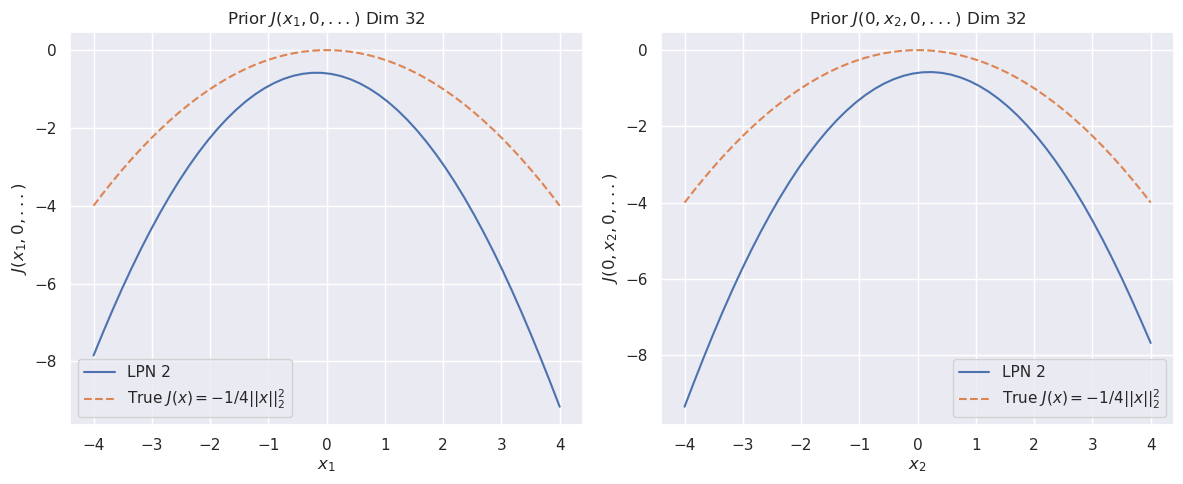

In [16]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)